In [1]:
import pandas as pd
import numpy as np

### Are peptide-generating genes forming clusters along the chromosomes?

Clustering method


Notebook by Assya Trofimov


In [51]:
#Select your chromosome here
selected_chr = 18

In [52]:
### Download the distance matrices files and unzip them
### This will select the correct distance matrix file and load it into python
dist = pd.read_csv(f'distances_matrices/chr{selected_chr}_distances.csv', index_col=0)

In [53]:
### Spot check to make sure the same genes are in the indices and columns 
dist = dist[dist.columns[dist.columns.isin(dist.index)]]

In [54]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [55]:
### Here we load the peptide file. Replace with your own
peptides = pd.read_csv('immunopep_breast2_lung6_ov23.csv', index_col=0)

In [71]:
### Here we select the peptide threshold.
### Note: The threshold is not included! (strictly greater than)

threshold = 0
### Selecting only the genes generating at least the threshold+1.
peptides = peptides[peptides['peptide_number']>threshold]

In [72]:
### Selecting only the peptides on the selected chromosome
peptides = peptides[peptides['chromosome_name']==str(selected_chr)]

In [73]:
### Here we create a vector that will contain either the word source or non-source. This will be useful later
generates_map = dist.index.isin(peptides['ensembl_gene_id'])
generates_map = ['source' if i else 'non-source' for i in generates_map]
generates_map = pd.DataFrame(generates_map)[0]

In [74]:
### Small adjustment for NA values - TODO - do they even exist?
dist = dist.fillna(np.max(dist))

In [77]:
### Saving the gene names
genes = dist.index
nbgenes = np.where(generates_map == 'source')[0].shape[0]
print (f'there are {nbgenes} peptide-generating genes on this chromosome')

there are 126 peptide-generating genes on this chromosome


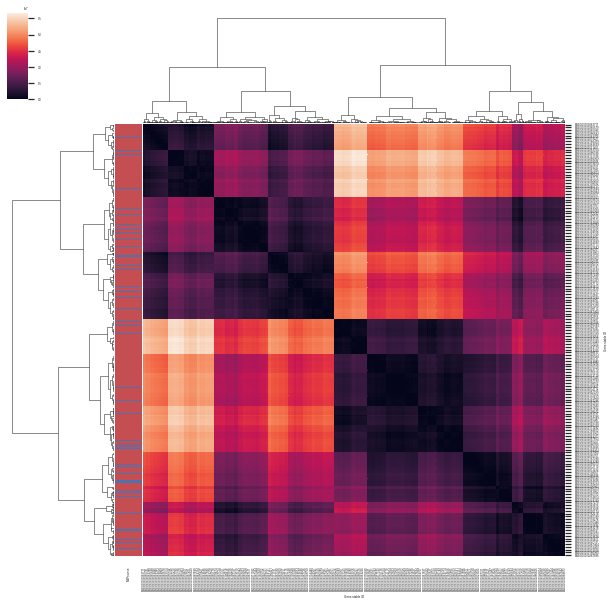

In [78]:
### This plots the heatmap with the column of source/non-source on the left
### It might take some time...
sns.set(font_scale=0.25)
lut = dict(zip(generates_map.unique(), "rb"))
row_colors = generates_map.map(lut)
row_colors.name = 'MAPsource'
row_colors.index = genes
dist = np.array(dist)
dist = pd.DataFrame(dist)
dist.index = genes
dist.columns = genes

g = sns.clustermap(dist, row_colors=row_colors)


In this section of the notebook we are creating the hierarchical clustering tree and cutting it at all heights in order to measure the enrichment for genes sources of peptides.

There are 2 options:
+ `balanced = False` perform the analysis on all genes on the chromosome
+ `balanced = True` perform the analysis on the genes sources of peptides and a the same number of randomly selected genes

In [83]:
### here we select the option
balanced = True

if balanced:
    positive_ix = np.where(generates_map == 'source')[0]
    negative_ix = np.random.permutation(np.where(np.logical_not(generates_map == 'source'))[0])[:positive_ix.shape[0]]
    keep = np.hstack((positive_ix, negative_ix))
    row_colors = row_colors[keep]
    dist = dist.iloc[keep,keep]

In [84]:
from scipy.cluster.hierarchy import linkage

In [85]:
Z = linkage(np.array(dist), 'single')

In [89]:
from scipy.cluster.hierarchy import fcluster
from  sklearn.metrics import v_measure_score as vm

In [92]:
### this function outputs the majority vote for a set of values
def majority(list_vals):
    return Counter(list_vals).most_common(1)[0][0]

In [93]:
### This function is used to get the votes for the normalization
def get_votes(c1,c2):
    newdict = {}
    for i in list(set(c2)):
        vote =  (majority(c1[np.where(c2==i)[0]]))
        newdict[i] = vote
    c3 = [newdict[i] for i in c2]
    return c3

In [95]:
from collections import Counter
from sklearn.metrics import matthews_corrcoef as mcc
import warnings
warnings.simplefilter("ignore")

### we will be storing various measurements below
### Either the v-measurements for the random and the real values
### or the Mathew Correlation Coefficient for the random and the real values
vms_random = []
vms_majority = []

mcc_random = []
mcc_majority = []


### In this loop we iteratively cut all possible ways the dendrogram and obtain clusters.
### For each cluster we measure the V-measure and the MCC in accordance to the majority vote by cluster
for k in range(2,dist.shape[0]):
    if k%100==0:
        print (f'{k}/{dist.shape[0]}')
    ### Here we get the cluster assignment 
    clusters = fcluster(Z, k, criterion='maxclust')
    ### here we get the votes for each cluster
    cluster_majority = get_votes(row_colors,clusters)
    
    ### Here we get the enrichment by v-measure of the real data
    vms_majority.append(vm(cluster_majority, row_colors))
    ### Here we permute the values to show the random
    permut = np.random.permutation(np.array(row_colors))
    ### Here we get the enrichment by v-measure of the random data
    vms_random.append(vm(clusters,permut))
    ### Here we get the enrichment by MCC of the random data
    mcc_random.append(mcc(cluster_majority, permut))
    ### Here we get the enrichment by MCC of the real data
    mcc_majority.append(mcc(cluster_majority, row_colors))

100/252
200/252


### Plotting the figures

Below both code snippets plot the two figures that can show the distance from random for each cluster number

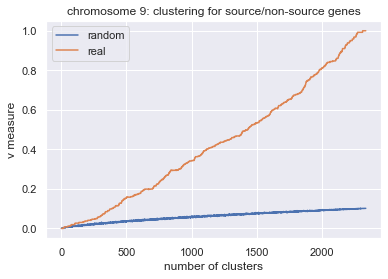

In [47]:
sns.set(font_scale=1)
if balanced:
    figure_name = f'Real_vs_Random_balanced_clustering_chr{selected_chr}_VM.png'
else:
    figure_name = f'Real_vs_Random_full_clustering_chr{selected_chr}_VM.png'

plt.plot(range(2,dist.shape[0]), vms_random,label='random')
plt.plot(range(2,dist.shape[0]), vms_majority,label='real')

plt.legend()
plt.xlabel('number of clusters')
plt.ylabel('v measure')
plt.title(f'chromosome {selected_chr}: clustering for source/non-source genes')
plt.savefig(figure_name)

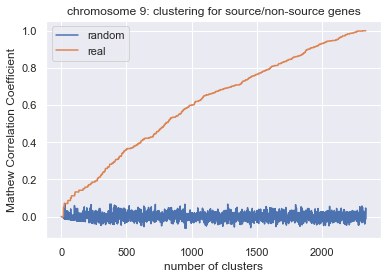

In [48]:
sns.set(font_scale=1)
if balanced:
    figure_name = f'Real_vs_Random_balanced_clustering_chr{selected_chr}_MCC.png'
else:
    figure_name = f'Real_vs_Random_full_clustering_chr{selected_chr}_MCC.png'


plt.plot(range(2,dist.shape[0]), mcc_random,label='random')
plt.plot(range(2,dist.shape[0]), mcc_majority,label='real')

plt.legend()
plt.xlabel('number of clusters')
plt.ylabel('Mathew Correlation Coefficient')
plt.title(f'chromosome {selected_chr}: clustering for source/non-source genes')
plt.savefig(figure_name)